In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress 
import numpy as np
import math
import matplotlib.ticker as ticker
from scipy.odr import ODR, Model, Data, RealData


In [170]:
# First method for finding the saturation value. Compares i with i+1 at a certain level in %
def find_saturation_value(column_data):
    for i in range(len(column_data) - 1):
        if abs(column_data.iloc[i] - column_data.iloc[i + 1]) <= 0.01 * abs(column_data.iloc[i]):
            saturation = column_data.iloc[i]
            break
        else:
            saturation = None
    return saturation


In [171]:
lowLevel_plot = True 
highLevel_plot = True
verbose = True
pedestal_plot = True

In [269]:
def find_saturation_from_derivate(T):
        
        T.sort_values(by=['meanADC'])
        # Extract x and y values
        x = T['meanRefPD'].values
        y = T['meanADC'].values

        # Compute the first derivative using central differences
        dy_dx = np.gradient(y, x)

        # Add the derivative to the DataFrame
        T['dy_dx'] = dy_dx
        #print(T['dy_dx'])
        
        # Define a threshold for identifying the plateau
        threshold = 0.5

        # Identify indices where dy_dx is not flat
        #non_flat_indices_aux = np.where(np.abs(dy_dx) >= threshold)[0]

        # Get some extra distance to be sure that there is a reduced number of flat indices
        #non_flat_indices = non_flat_indices_aux[:-5]


        flat_indices = np.where(np.abs(dy_dx) < threshold)[0]
        if flat_indices.size > 0:
                # Find the index and shift it by two for safety
                first_flat_index = flat_indices[0] 
                satADC=y[first_flat_index]
                safe_index = first_flat_index -2
                T_non_flat = T.iloc[:safe_index]
        else:
                satADC=-1
                T_non_flat = T
        
        #print(satADC)
        # Extract the corresponding rows
        #T_non_flat = T.iloc[non_flat_indices]
        
        return T_non_flat, satADC

In [270]:
def ObtainMeanAndStd(mean_values,err_values):
    safe_stderr = np.where(err_values.values == 0, 1e-10, err_values.values)
    weights = 1 / np.array(safe_stderr)**2
    weighted_mean = np.sum(weights * mean_values) / np.sum(weights)
    weighted_mean_error = np.sqrt(1 / np.sum(weights))
    weighted_variance = np.sum(weights * (mean_values - weighted_mean)**2) / np.sum(weights)
    weighted_std_dev = np.sqrt(weighted_variance)
    return weighted_mean, weighted_std_dev


In [293]:
def ADC_analysis(folder_path,dataset_number,output_path,output_path_lowlevel,datetest,boardname):

    outputpath = f"{output_path}"
    outputpath_lowlevel = f"{output_path_lowlevel}"

    sensorsID = ['0.0','0.1','0.2','0.3','1.0','1.1','1.2','1.3','2.0','2.1','2.2','2.3','3.0','3.1','3.2','3.3','4.0','4.1','4.2','4.3']
    wavelength = ['1064','532']
   
    if not os.path.exists(outputpath_lowlevel):
        os.makedirs(outputpath_lowlevel)
        os.makedirs(outputpath)
        print(f"Directory '{outputpath_lowlevel}' created.")

    if not os.path.exists(outputpath):
        os.makedirs(outputpath)
        print(f"Directory '{outputpath}' created.")

    for wl in wavelength:
        pedestalsADC = []
        pedestalsADC_stderr = []
        pedestalsRefPD = []
        pedestalsRefPD_stderr = []
        slopes = []
        intercepts= []
        rCoes = []
        slopes_stderr = []
        intercepts_stderr = []
        saturationADCs = []
        if wl== '532':
        # Rename DataFrame columns
            strg_L = 'Laser Current (mA)'
            #temp = '20'
        elif wl == '1064':
            strg_L = 'Laser Power (mW)'
            #temp = '25'

        for l in sensorsID:
            sensorID=l
            pedestal_list = []
            main_list = []
            for number in np.arange(1,dataset_number+1):
                filename = f'{folder_path}/{datetest}_{boardname}_{sensorID}_{wl}_{number}.txt'
                # Read the first line as a separate DataFrame
                df = pd.read_csv(filename, sep="\t", header=None)
                
                # Split the first row into a separate DataFrame
                first_row = df.iloc[[0]]  # Select the first row as a DataFrame
                last_row = df.iloc[[-1]]
                pedestal_list.append(first_row)  # Add the first row to pedestal list
                pedestal_list.append(last_row)  # Add the first row to pedestal list

                # Get the remaining rows (from the second row onward)
                main_data = df.iloc[1:-1]  # Select all rows except the first and last
                main_list.append(main_data)  # Add to main data list

            # Concatenate the first rows (metadata or header info) and the main data
            TP = pd.concat(pedestal_list, ignore_index=True)
            T = pd.concat(main_list, ignore_index=True)
            TP.columns = ['Date-Hour', 'L', 'TotalSum', 'TotalSquareSum', 'meanRefPD', 'stdRefPD', 'Tem', 'RH', 'TotalCounts']
            T.columns = ['Date-Hour', 'L', 'TotalSum', 'TotalSquareSum', 'meanRefPD', 'stdRefPD', 'Tem', 'RH', 'TotalCounts']

            meanADC = T['TotalSum']/T['TotalCounts']
            stdADC = np.sqrt((T['TotalSquareSum']-T['TotalCounts']*meanADC**2)/(T['TotalCounts']-1))
            T['meanADC'] = meanADC
            T['stdADC'] = stdADC
            
            pedestal_meanADC = TP['TotalSum']/TP['TotalCounts']
            TP['meanADC'] = pedestal_meanADC
            TP['stdADC'] = np.sqrt((TP['TotalSquareSum']-TP['TotalCounts']*pedestal_meanADC**2)/(TP['TotalCounts']-1))

            # meanPM = meanADC*0.61e-3 #0.61mV/ADCcount  
            # stdPM = stdADC*0.61e-3
            # # T['meanPM']=meanPM
            # T['stdPM']=stdPM
        
            T, saturationADC = find_saturation_from_derivate(T)

            res = linregress(T['meanRefPD'], T['meanADC'])
            '''
            def linear_model(params, x):
                m, b = params
                return m * x + b

            # Prepare the data with errors
            data = RealData(T['meanRefPD'], T['meanADC'], sx=T['stdRefPD'], sy=T['stdADC'])

            # Create the model
            model = Model(linear_model)

            # Set up ODR with data and model
            odr = ODR(data, model, beta0=[1.0, 1.0])  # Initial guess for [slope, intercept]

            # Run the regression
            output = odr.run()

            # Extract results
            slope, intercept = output.beta
            slope_err, intercept_err = output.sd_beta
            
            slopes.append(slope)
            intercepts.append(intercept)
            rCoes.append(res.rvalue)
            slopes_stderr.append(slope_err)
            intercepts_stderr.append(intercept_err)
            saturationADCs.append(saturationADC)
            '''
            slopes.append(res.slope)
            intercepts.append(res.intercept)
            rCoes.append(res.rvalue)
            slopes_stderr.append(res.stderr)
            intercepts_stderr.append(res.intercept_stderr)
            saturationADCs.append(saturationADC)
            
            pedestalsADC_wmean, pedestalsADC_wstderr = ObtainMeanAndStd(TP['meanADC'],TP['stdADC'])
            pedestalsPD_wmean, pedestalsPD_wstderr = ObtainMeanAndStd(TP['meanRefPD'],TP['stdRefPD'])


            pedestalsADC.append(pedestalsADC_wmean)
            pedestalsADC_stderr.append(pedestalsADC_wstderr) # This errors should be added in quadrature
            pedestalsRefPD.append(pedestalsPD_wmean) 
            pedestalsRefPD_stderr.append(pedestalsPD_wstderr)# This errors should be added in quadrature


            if(verbose):
                print(f'Calibration coefficient found for sensorID {sensorID} for laser {wl} nm = {res.slope} +/- {res.stderr} in ADC/V')

            if(lowLevel_plot):
                fig = plt.figure(2)
                plt.errorbar(T['L'], T['meanADC'], yerr=T['stdADC'], fmt='.', markersize=10, linewidth=1)
                plt.ylabel('mean ADC counts')
                plt.xlabel(strg_L)
                plt.grid()
                plt.title(f'Plot sensorID {sensorID}, wavelength {wl} nm')
                plt.tight_layout()
                plt.savefig(f'{outputpath_lowlevel}/{datetest}_{boardname}_{sensorID}_{wl}_meanADC_L.png',dpi=199)  # Display the current figure
                plt.close(fig)

                fig = plt.figure(4)
                plt.errorbar(T['L'], T['meanRefPD'], yerr=T['stdRefPD'], fmt='.', markersize=10, linewidth=1)
                plt.ylabel('Mean ref PD (V)')
                plt.xlabel(strg_L)
                plt.grid()
                plt.title(f'Plot sensorID {sensorID}, wavelength {wl} nm')
                plt.tight_layout()
                plt.savefig(f'{outputpath_lowlevel}/{datetest}_{boardname}_{sensorID}_{wl}_meanRefPD_L.png',dpi=199)  # Display the current figure
                #plt.show()
                plt.close(fig)

                #the label here are incorrect since meanPM=meanADC*0.61e-3 #0.61mV/ADCcoun. Monica proposed from the baffle paper: 
                #Voltage/ADCcount =3.3V/2**10=0.00322 V/ADCcount
                #4.6 uW/ADCcount*1ADCcount/0.00322V = 1428 uW/V


                fig = plt.figure(6)
                plt.errorbar(T['meanRefPD'], T['meanADC'], yerr=T['stdADC'], fmt='.', markersize=10, linewidth=1)
                plt.plot(T['meanRefPD'], res.intercept + res.slope*T['meanRefPD'], 'r', label='fitted line')
                plt.ylabel('Mean ADC counts')
                plt.xlabel('Mean ref PD (V)')
                plt.grid()
                plt.title(f'Plot sensorID {sensorID}, wavelength {wl} nm')
                plt.tight_layout()
                plt.savefig(f'{outputpath_lowlevel}/{datetest}_{boardname}_{sensorID}_{wl}_meanADC_meanRefPD.png',dpi=199)  # Display the current figure
                #plt.show()
                plt.close(fig)
            
        if(highLevel_plot):
                tabdata = pd.DataFrame()
                tabdata["sensorID"] = sensorsID
                tabdata["slope"] = slopes
                tabdata["intercept"] = intercepts
                tabdata["rCoe"] = rCoes
                tabdata["slopes_stderr"] = slopes_stderr
                tabdata["intercept_stderr"] = intercepts_stderr
                tabdata["saturationADC"] = saturationADCs
                
                fig = plt.figure(300)
                plt.errorbar(range(len(intercepts)), intercepts,intercepts_stderr, fmt='.',  markersize=10, linewidth=1)
                plt.axhline(y=np.mean(intercepts), color='tab:olive', linestyle='-')
                plt.fill_between(range(-1,len(intercepts)+1), (np.mean(intercepts)-np.std(intercepts)), (np.mean(intercepts)+np.std(intercepts)), color='tab:olive', alpha=0.2)
                plt.title(f'Intercepts at {wl} nm. Value = {np.mean(intercepts):.1f} +- {np.std(intercepts):.1f}')
                plt.xlabel('SensorID')
                plt.ylabel('ADC counts')
                plt.xticks(np.arange(len(intercepts)), sensorsID, rotation=20)
                plt.xlim([-1,len(sensorsID)])
                plt.grid()
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_noshade_intercepts.png',dpi=199)  # Display the current figure
                plt.close()
                
                fig = plt.figure(400)
                plt.errorbar(range(len(rCoes)), rCoes, fmt='.', markersize=10,linewidth=1)
                plt.axhline(y=np.mean(rCoes), color='tab:olive', linestyle='-')
                plt.fill_between(range(-1,len(rCoes)+1), (np.mean(rCoes)-np.std(rCoes)), (np.mean(rCoes)+np.std(rCoes)), color='tab:olive', alpha=0.2)
                plt.title(f'rCoes at {wl} nm. Value = {np.mean(rCoes):.1f} +- {np.std(rCoes):.1f}')
                plt.xlabel('SensorID')
                plt.ylabel('')
                plt.xticks(np.arange(len(rCoes)), sensorsID, rotation=20)
                plt.xlim([-1,len(sensorsID)])
                plt.grid()
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_rcoes.png',dpi=199)  # Display the current figure
                plt.close()
                
                fig = plt.figure(500)
                plt.title(f'Saturation ADC at {wl} nm. Value = {np.mean(saturationADCs):.1f} +- {np.std(saturationADCs):.1f}')
                plt.plot(range(len(saturationADCs)), saturationADCs,'.')
                plt.axhline(y=np.mean(saturationADCs), color='tab:olive', linestyle='-')
                plt.fill_between(range(-1,len(saturationADCs)+1), (np.mean(saturationADCs)-np.std(saturationADCs)), (np.mean(saturationADCs)+np.std(saturationADCs)), color='tab:olive', alpha=0.2)
                plt.xlabel('SensorID')
                plt.ylabel('')
                plt.xticks(np.arange(len(saturationADCs)), sensorsID, rotation=20)
                plt.xlim([-1,len(sensorsID)])
                plt.grid()
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_saturationADC.png',dpi=199)  # Display the current figure
                plt.close()

                sensorsID1=sensorsID[:16]
                sensorsID2=sensorsID[-4:]
                slopes1=slopes[:16]
                slopes2=slopes[-4:]
                intercepts1=intercepts[:16]
                intercepts2=intercepts[-4:]
                rCoes1=rCoes[:16]
                rCoes2=rCoes[-4:]
                slopes_stderr1=slopes_stderr[:16]
                slopes_stderr2=slopes_stderr[-4:]
                intercepts_stderr1=intercepts_stderr[:16]
                intercepts_stderr2=intercepts_stderr[-4:]
                saturationADCs1=saturationADCs[:16]
                saturationADCs2=saturationADCs[-4:]
                
                #Uncertainty of Weighted Mean: Precision based on individual measurement uncertainties.
                #Intervariability: Variability among the measurements (random error, i.e. embedded systematic uncertainties).
                #Purely Systematic Error: Accounts for known or estimated biases in the measurements (temperature/humidity????)

                weights1 = 1 / np.array(slopes_stderr1)**2
                weighted_mean1 = np.sum(weights1 * slopes1) / np.sum(weights1)
                weighted_mean_error1 = np.sqrt(1 / np.sum(weights1))
                weighted_variance1 = np.sum(weights1 * (slopes1 - weighted_mean1)**2) / np.sum(weights1)
                weighted_std_dev1 = np.sqrt(weighted_variance1)
                intervariability1 = np.std(slopes1, ddof=1)  # Standard deviation (sample)
                combined_sigma1 = np.sqrt(weighted_std_dev1**2+intervariability1**2)
                
                weights2 = 1 / np.array(slopes_stderr2)**2
                weighted_mean2 = np.sum(weights2 * slopes2) / np.sum(weights2)
                weighted_mean_error2 = np.sqrt(1 / np.sum(weights2))
                weighted_variance2 = np.sum(weights2 * (slopes2 - weighted_mean2)**2) / np.sum(weights2)
                weighted_std_dev2 = np.sqrt(weighted_variance2)
                intervariability2 = np.std(slopes2, ddof=1)  # Standard deviation (sample)
                combined_sigma2 = np.sqrt(weighted_std_dev2**2+intervariability2**2)

                ringwog=[slopes[0],slopes[1],slopes[2],slopes[3],slopes[4],slopes[5],slopes[6],slopes[7],slopes[8],slopes[9],slopes[10],slopes[11],slopes[12],slopes[13],slopes[14],slopes[15]]
                ringwg=[slopes[16],slopes[17],slopes[18],slopes[19]]
                
                meanwog = np.mean(ringwog)
                meanwg = np.mean(ringwg)
                gain = weighted_mean2/weighted_mean1
                deviationwog = np.std(ringwog)
                deviationwg = np.std(ringwg)
               
                gainerror=gain*math.sqrt(weighted_std_dev2/(weighted_mean2**2)+weighted_std_dev1/(weighted_mean1**2))
                print('--------------------------------------------------------------------------------------------')
                print(f'Mean characterization ring 0-3, {wl} = {meanwog} +- {deviationwog}. The error in percent is: {100*deviationwog/meanwog}$%$')
                print(f'Weighted mean characterization ring 0-3, {wl} = {weighted_mean1} +- {weighted_mean_error1}. The error in percent is: {100*weighted_mean_error1/weighted_mean1}$%$')
                print(f'Weighted standard deviation (spread): {weighted_std_dev1}')
                print(f'Standard deviation of the measurements, intervariability: {intervariability1}')
                print(f'Total combined error:{combined_sigma1}')
                print(f'=> Weighted characterization ring 0-3, {wl} = {weighted_mean1} +- {combined_sigma1}. The error in percent is: {100*combined_sigma1/weighted_mean1}$%$')

                
                print(f'Mean characterization ring 4 {wl} = {meanwg} +- {deviationwg}. The error in percent is: {100*deviationwg/meanwg}$%$')
                print(f'Weighted mean characterization ring 4, {wl} = {weighted_mean2} +- {weighted_mean_error2}. The error in percent is: {100*weighted_mean_error2/weighted_mean2}$%$')
                print(f'Weighted standard deviation (spread): {weighted_std_dev2}')
                print(f'Standard deviation of the measurements, intervariability: {intervariability2}')
                print(f'Total combined error:{combined_sigma2}')
                print(f'=> Weighted characterization ring 4, {wl} = {weighted_mean2} +- {combined_sigma2}. The error in percent is: {100*combined_sigma2/weighted_mean2}$%$')
                
                print(f"==> Gain for ring 4 vs. 1-3 from weighted mean,{wl} = {gain} +- {gainerror}. The error in percent is: {100*gainerror/gain}$%$")

                print('--------------------------------------------------------------------------------------------')


                fig = plt.figure(101)
                plt.errorbar(range(len(slopes1)),slopes1,slopes_stderr1,fmt='.',color='tab:purple',markersize=10,linewidth=1)
                plt.axhline(y=weighted_mean1, color='tab:olive', linestyle='-', label='wmean ADC/V')
                plt.fill_between(range(-1,len(slopes1)+1), (weighted_mean1-weighted_std_dev1), (weighted_mean1+weighted_std_dev1), color='tab:olive', alpha=0.2, label= '${\sigma}_{weightStd}$')
                plt.fill_between(range(-1,len(slopes1)+1), (weighted_mean1-combined_sigma1), (weighted_mean1+combined_sigma1), color='tab:cyan', alpha=0.2, label= '${\sigma}_{weightStd} + {\sigma}_{intervar} $')
                # plt.axhline(y=np.mean(slopes1), color='tab:olive', linestyle='-', label='mean ADC/V')
                # plt.fill_between(range(-1,len(slopes1)+1), (np.mean(slopes1)-np.std(slopes1)), (np.mean(slopes1)+np.std(slopes1)), color='tab:olive', alpha=0.2)
                plt.title(f'Sensors char at {wl} nm. Value =  {weighted_mean1:.1f} +- {combined_sigma1:.1f} ADC/V ({100*combined_sigma1/weighted_mean1:.1f}%)')
                plt.xlabel('SensorID')
                plt.ylabel('ADC counts/V')
                plt.xticks(np.arange(len(slopes1)), sensorsID1, rotation=20)
                plt.xlim([-1,len(sensorsID1)]) 
                plt.grid()
                plt.legend()
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_calibration_0_3.png',dpi=199)  # Display the current figure
                plt.close()
                
                if(lowLevel_plot):

                    fig = plt.figure(200)
                    plt.errorbar(range(len(slopes_stderr1)), slopes_stderr1, fmt='.',color='tab:purple', markersize=10, linewidth=1)
                    plt.axhline(y=np.mean(slopes_stderr1), color='tab:olive', linestyle='-', label='mean ADC/V')
                    plt.fill_between(range(-1,len(slopes_stderr1)+1), (np.mean(slopes_stderr1)-np.std(slopes_stderr1)), (np.mean(slopes_stderr1)+np.std(slopes_stderr1)), color='tab:olive', alpha=0.2)
                    plt.title(f'Stderr at {wl} nm. Value = {np.mean(slopes_stderr1):.1f} +- {np.std(slopes_stderr1):.1f}')
                    plt.xlabel('SensorID')
                    plt.ylabel('ADC counts/V')
                    plt.xticks(np.arange(len(slopes_stderr1)), sensorsID1, rotation=20)
                    plt.xlim([-1,len(sensorsID1)])
                    plt.grid()
                    plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_calibration_stderrs_0_3.png',dpi=199)  # Display the current figure
                    plt.close()

                fig = plt.figure(102)
                plt.errorbar(range(len(slopes2)), slopes2, slopes_stderr2, fmt='.',color='tab:purple', markersize=10, linewidth=1)
                plt.axhline(y=weighted_mean2, color='tab:olive', linestyle='-', label='wmean ADC/V')
                plt.fill_between(range(-1,len(slopes2)+1), (weighted_mean2-weighted_std_dev2), (weighted_mean2+weighted_std_dev2), color='tab:olive', alpha=0.2, label= '${\sigma}_{weightStd} $')
                plt.fill_between(range(-1,len(slopes2)+1), (weighted_mean2-combined_sigma2), (weighted_mean2+combined_sigma2), color='tab:cyan', alpha=0.2,label= '${\sigma}_{weightStd} + {\sigma}_{intervar} $')
                #plt.axhline(y=np.mean(slopes2), color='tab:olive', linestyle='-', label='mean ADC/V')
                #plt.fill_between(range(-1,len(slopes2)+1), (np.mean(slopes2)-np.std(slopes2)), (np.mean(slopes2)+np.std(slopes2)), color='tab:olive', alpha=0.2)
                plt.title(f'Sensors char at {wl} nm. Value = {weighted_mean2:.1f} +- {combined_sigma2:.1f} ADC/V ({100*combined_sigma2/weighted_mean2:.1f}%)')
                plt.xlabel('SensorID')
                plt.ylabel('ADC counts/V')
                plt.xticks(np.arange(len(slopes2)), sensorsID2, rotation=20)
                plt.xlim([-1,len(sensorsID2)]) 
                plt.grid()
                plt.legend()
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_calibration_4.png',dpi=199)  # Display the current figure
                plt.close()
                
                if(lowLevel_plot):
                    fig = plt.figure(200)
                    plt.errorbar(range(len(slopes_stderr2)), slopes_stderr2, fmt='.', color='tab:purple', markersize=10, linewidth=1)
                    plt.axhline(y=np.mean(slopes_stderr2), color='tab:olive', linestyle='-', label='mean ADC/V')
                    plt.fill_between(range(-1,len(slopes_stderr2)+1), (np.mean(slopes_stderr2)-np.std(slopes_stderr2)), (np.mean(slopes_stderr2)+np.std(slopes_stderr2)), color='tab:olive', alpha=0.2)
                    plt.title(f'Stderr at {wl} nm. Value = {np.mean(slopes_stderr2):.1f} +- {np.std(slopes_stderr2):.1f}')
                    plt.xlabel('SensorID')
                    plt.ylabel('ADC counts/V')
                    plt.xticks(np.arange(len(slopes_stderr2)), sensorsID2, rotation=20)
                    plt.xlim([-1,len(sensorsID2)])
                    plt.grid()
                    plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_calibration_stderrs_4.png',dpi=199)  # Display the current figure
                    plt.close()
        if(pedestal_plot):
            fig =  plt.figure(11)
            plt.errorbar(range(len(pedestalsADC)),pedestalsADC, pedestalsADC_stderr, fmt='.',color='tab:purple', markersize=10, linewidth=1)
            plt.xlabel('SensorID')
            plt.ylabel('ADC counts')
            plt.xticks(range(len(pedestalsADC)), sensorsID, rotation=20)
            plt.xlim([-1,len(sensorsID)])
            plt.grid()
            plt.title(f'Pedestal of the ADC for measurement of {wl} laser')
            plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_pedestals_ADC.png',dpi=199)  # Display the current figure
            plt.close()
            
            fig =  plt.figure(12)
            plt.errorbar(range(len(pedestalsRefPD)),pedestalsRefPD, pedestalsRefPD_stderr, fmt='.',color='tab:purple', markersize=10, linewidth=1)
            plt.xlabel('SensorID')
            plt.ylabel('V')
            plt.xticks(range(len(pedestalsADC)), sensorsID, rotation=20)
            plt.xlim([-1,len(sensorsID)])
            plt.grid()
            plt.title(f'Pedestals of the PD reference for measurement of {wl} laser')
            plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_pedestals_RefPD.png',dpi=199)  # Display the current figure
            plt.close()

## ANALYSIS OF THE DATASET

In [294]:
ADC_analysis('./Data/setup2/20112024_9R1/data',3,"./Data/setup2/20112024_9R1/plots","./Data/setup2/20112024_9R1/plots/LowLevel",'20112024','9R1')

Calibration coefficient found for sensorID 0.0 for laser 1064 nm = 5218.1867200867555 +/- 6.7918249298993905 in ADC/V
Calibration coefficient found for sensorID 0.1 for laser 1064 nm = 5255.099131344526 +/- 7.705314524381683 in ADC/V
Calibration coefficient found for sensorID 0.2 for laser 1064 nm = 5086.076692352249 +/- 6.123933555164299 in ADC/V
Calibration coefficient found for sensorID 0.3 for laser 1064 nm = 5026.177790692133 +/- 6.558631204779469 in ADC/V
Calibration coefficient found for sensorID 1.0 for laser 1064 nm = 5181.018389564729 +/- 6.429077407250658 in ADC/V
Calibration coefficient found for sensorID 1.1 for laser 1064 nm = 5208.3454065460755 +/- 9.224708262787724 in ADC/V
Calibration coefficient found for sensorID 1.2 for laser 1064 nm = 5103.390430896798 +/- 6.522565905482894 in ADC/V
Calibration coefficient found for sensorID 1.3 for laser 1064 nm = 5066.002350741801 +/- 8.07726233040903 in ADC/V
Calibration coefficient found for sensorID 2.0 for laser 1064 nm = 511

In [295]:
# Merges dataset up to the number given, fits the data, and the coefficient is obtained 
ADC_analysis('./Data/setup2/28102024_4L2/data',3,"./Data/setup2/28102024_4L2/plots","./Data/setup2/28102024_4L2/plots/LowLevel",'28102024','4L2')


Calibration coefficient found for sensorID 0.0 for laser 1064 nm = 5214.760007484154 +/- 14.883664179854273 in ADC/V
Calibration coefficient found for sensorID 0.1 for laser 1064 nm = 5131.155067993221 +/- 9.281990117787121 in ADC/V
Calibration coefficient found for sensorID 0.2 for laser 1064 nm = 5160.999667660581 +/- 14.46100252875716 in ADC/V
Calibration coefficient found for sensorID 0.3 for laser 1064 nm = 5129.510691497277 +/- 12.860341555661407 in ADC/V
Calibration coefficient found for sensorID 1.0 for laser 1064 nm = 5099.8428931144745 +/- 7.775992820078564 in ADC/V
Calibration coefficient found for sensorID 1.1 for laser 1064 nm = 5135.229377280262 +/- 7.265788210726244 in ADC/V
Calibration coefficient found for sensorID 1.2 for laser 1064 nm = 5040.75937757786 +/- 8.797524385722053 in ADC/V
Calibration coefficient found for sensorID 1.3 for laser 1064 nm = 5069.919853585479 +/- 11.814283725180685 in ADC/V
Calibration coefficient found for sensorID 2.0 for laser 1064 nm = 51

## Stability

In [101]:
def MergeDatasets(folder_path):
    # Initialize an empty list to store individual DataFrames
    dataframes = []
    # Iterate over each file in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):  # Only process .txt files
            file_path = os.path.join(folder_path, file_name)
            sensor_id = file_name.split('.')[0]

            # Read the file into a pandas DataFrame
            df = pd.read_csv(file_path, sep='\t', header=None)
            
            # Assign the provided column names
            df.columns = ['Date-Time', 'Laser_Power', 'Total_Sum', 'Total_Sqr', 'V_Mean', 'Std_V', 'Temp', 'Humidity', 'Total_Counts']
            df.loc[:, 'pd_val'] = df['Total_Sum']/df['Total_Counts']
            df.loc[:, 'pd_val_norm'] = df['pd_val']/df['V_Mean']
            df.loc[:, 'sensor_id'] = sensor_id
            
            # Append the DataFrame to the list
            dataframes.append(df)

    # Concatenate all the DataFrames into one
    final_df = pd.concat(dataframes, ignore_index=True)

    # Display the first few rows of the concatenated DataFrame
    #print(final_df.head())
    return final_df

In [102]:
def Overall_Stability(final_df, columns_to_plot):
    # Create a plot for each column
    for column in columns_to_plot:
        # Calculate mean and variance
        mean_value = final_df[column].mean()
        std_dev = final_df[column].std()  # Standard deviation
        
        # Calculate sigma as a percentage of the mean
        sigma_percentage = (std_dev / mean_value) * 100 if mean_value != 0 else 0
        
        # Print mean and sigma (standard deviation)
        print(f'{column}:')
        print(f'  Mean: {mean_value}')
        print(f'  Standard Deviation (σ): {std_dev}')
        print(f'  Standard Deviation as Percentage of Mean: {sigma_percentage}%')
        
        
        # Create a subplot with 2 plots side by side (1 row, 2 columns)
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Adjust the figure size as necessary

        # Plot the evolution of values (line plot) on the left
        axs[0].plot(final_df[column], '.', color='orange')
        axs[0].set_title(f'{column} Evolution (Mean: {mean_value:.2f}, σ%: {sigma_percentage:.2f}%)')
        axs[0].set_xlabel('Index (Time Steps)')
        axs[0].set_ylabel(column)
        axs[0].grid(True)

        # Plot the histogram on the right
        axs[1].hist(final_df[column], bins=30, edgecolor='black', alpha=0.7)
        axs[1].set_title(f'{column} Histogram')
        axs[1].set_xlabel(column)
        axs[1].set_ylabel('Frequency')
        axs[1].grid(True)

        # Adjust the layout to prevent overlapping
        plt.tight_layout()
        
        # Show the combined plots
        plt.show()

## Check overall stability of the main variables

Laser_Power:
  Mean: 131.63416814159294
  Standard Deviation (σ): 122.46811832081184
  Standard Deviation as Percentage of Mean: 93.036724468892%


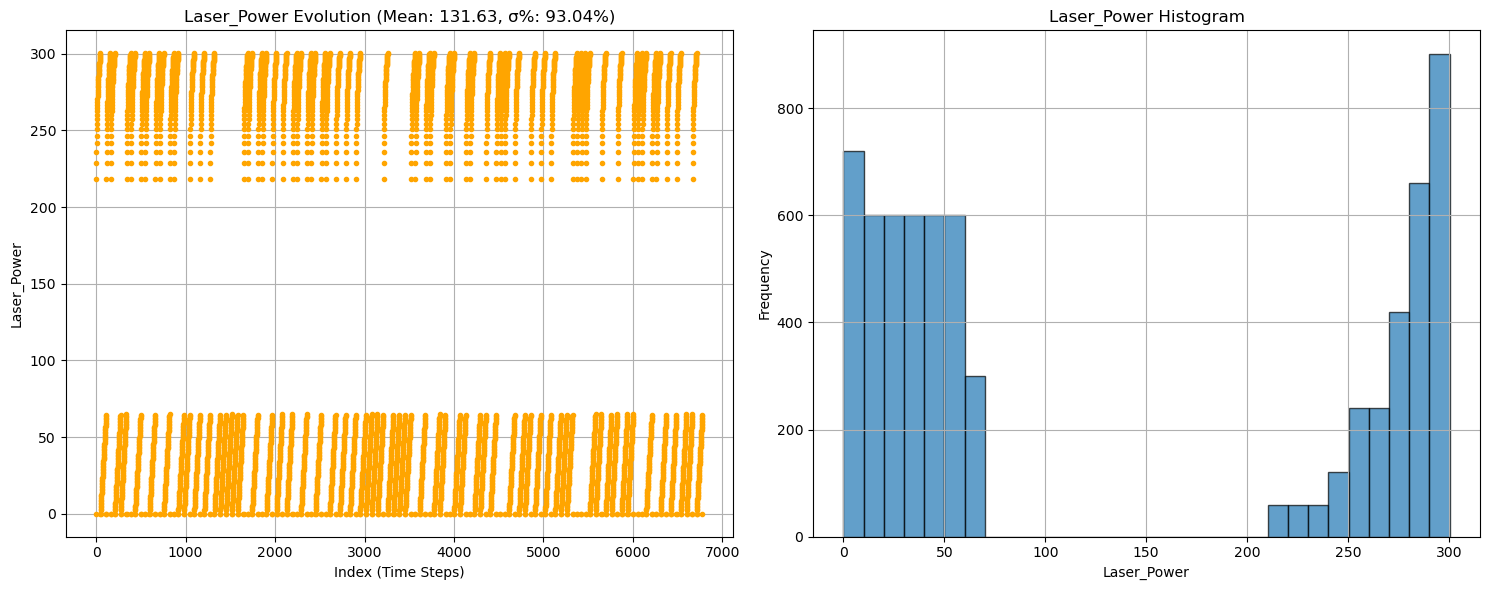

Total_Sum:
  Mean: 159163441.06238937
  Standard Deviation (σ): 95082362.80379857
  Standard Deviation as Percentage of Mean: 59.73882078016138%


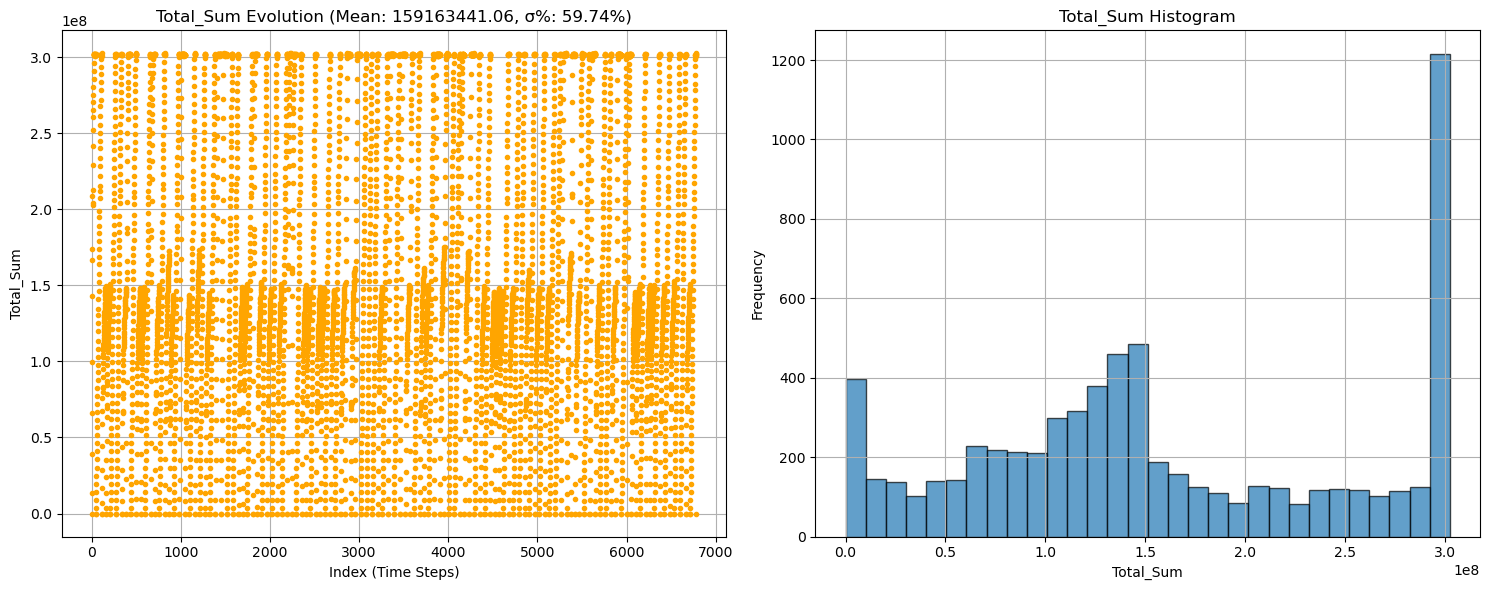

Total_Sqr:
  Mean: 466579266838.4597
  Standard Deviation (σ): 446537437087.7907
  Standard Deviation as Percentage of Mean: 95.70451771539862%


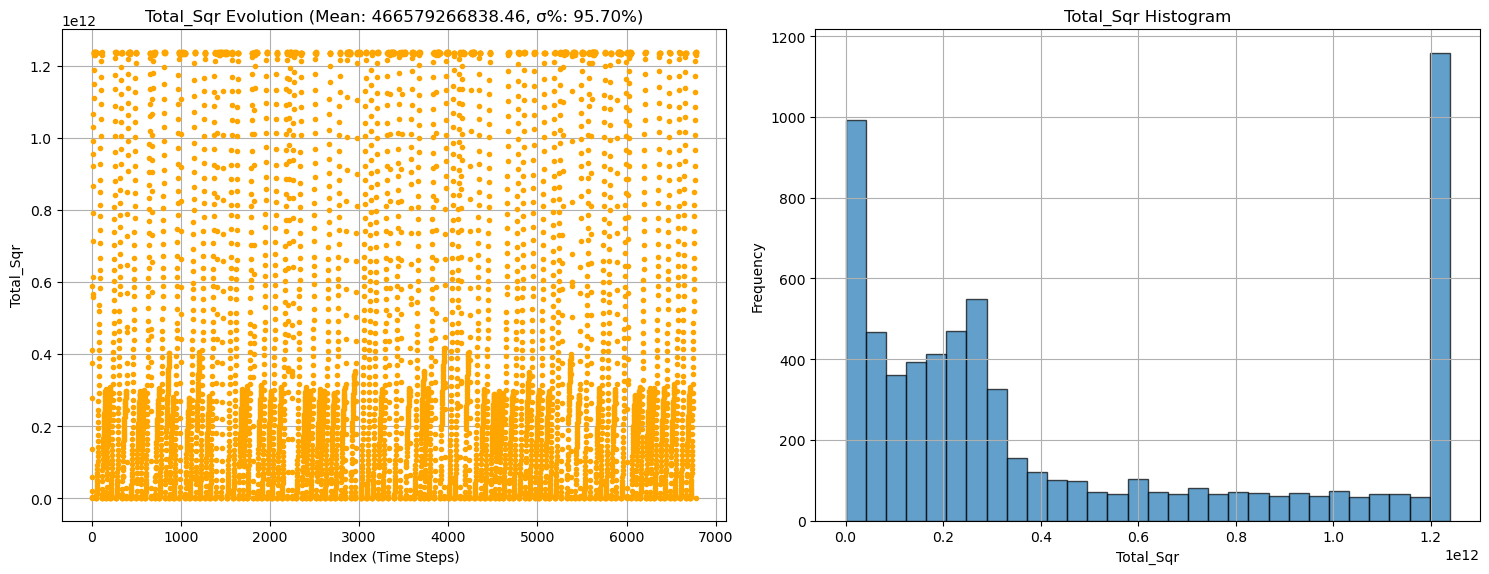

V_Mean:
  Mean: 0.5544281831122418
  Standard Deviation (σ): 0.30459405415539026
  Standard Deviation as Percentage of Mean: 54.93841464652355%


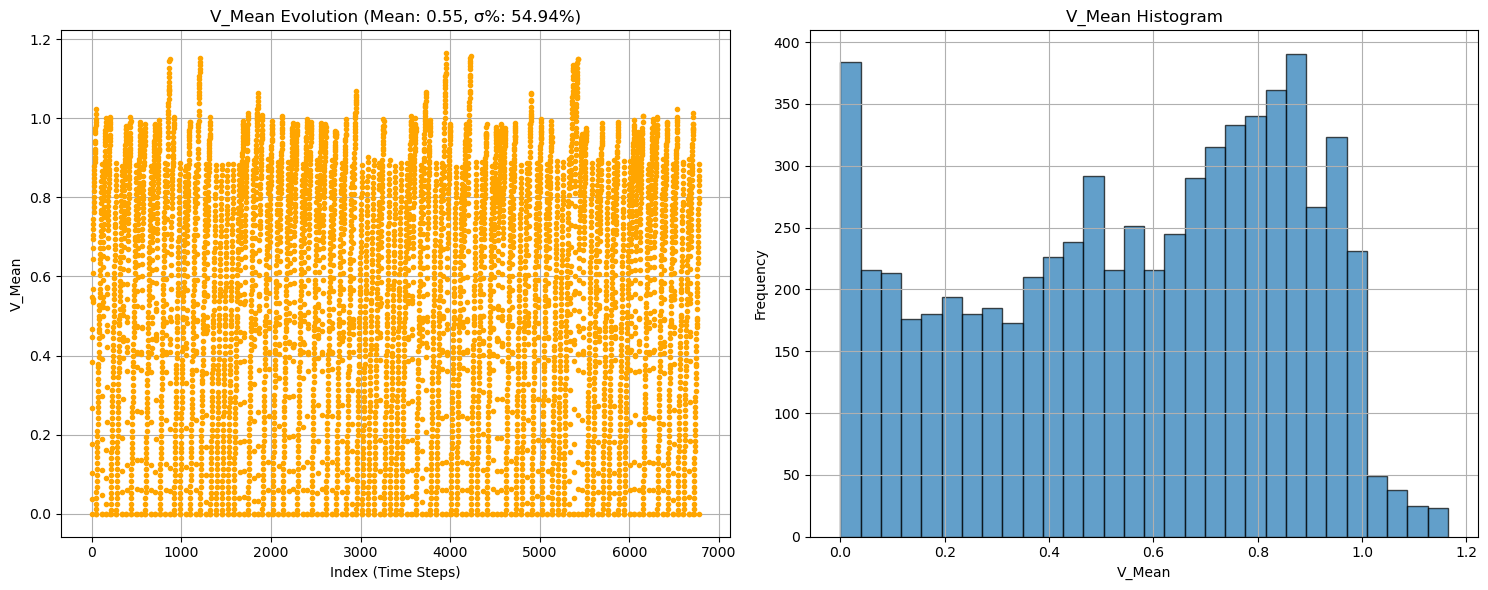

Std_V:
  Mean: 0.0009619948125368733
  Standard Deviation (σ): 0.0014423841143870117
  Standard Deviation as Percentage of Mean: 149.93678714163806%


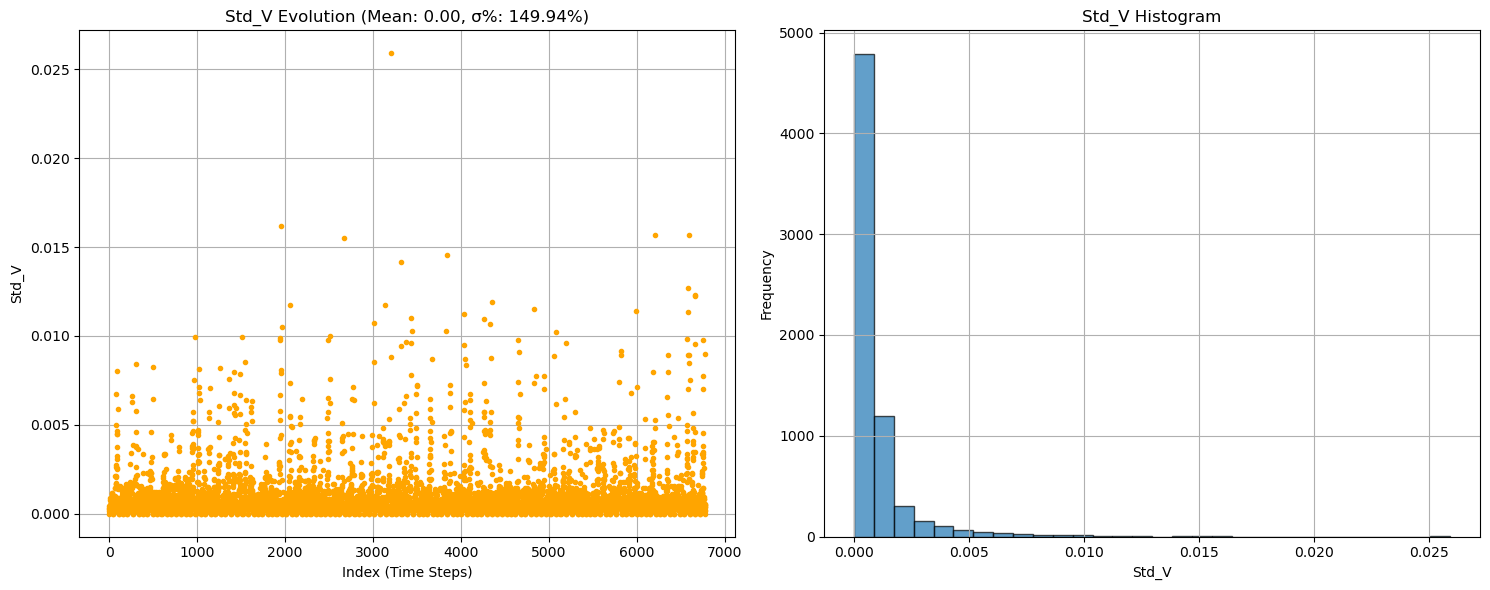

Temp:
  Mean: 21.108997050147494
  Standard Deviation (σ): 0.11826247366571377
  Standard Deviation as Percentage of Mean: 0.5602467676922975%


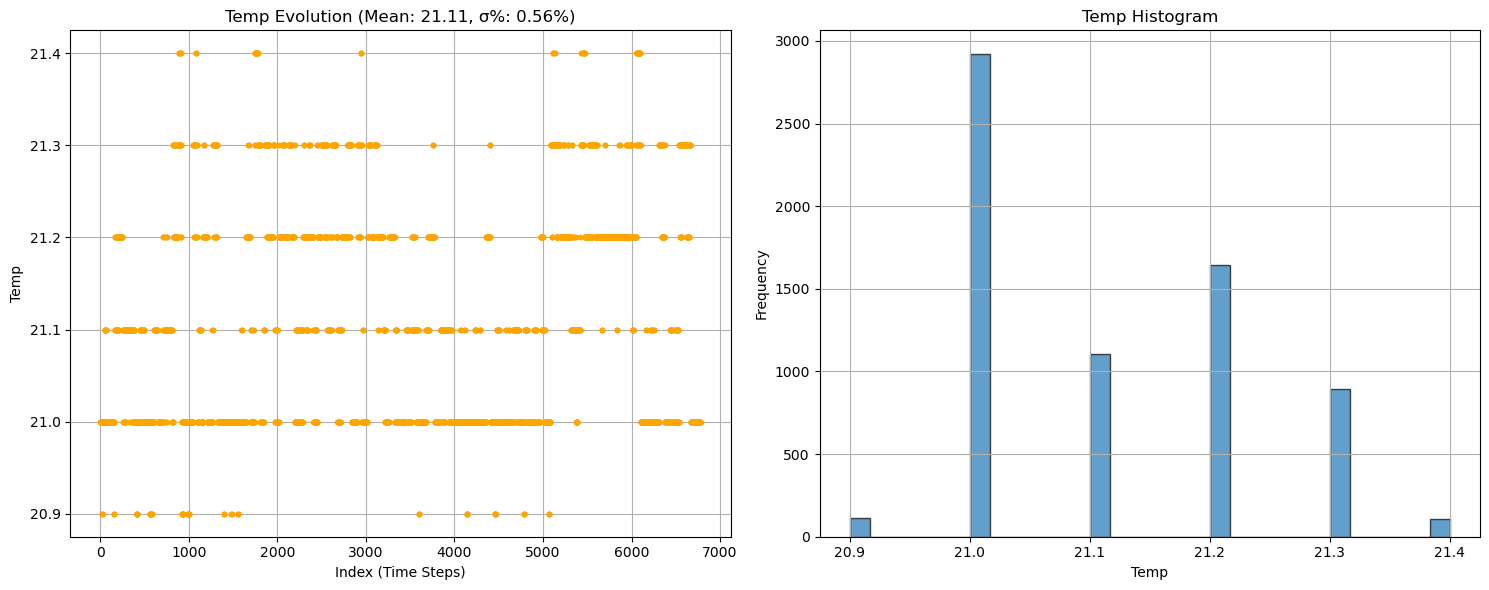

Humidity:
  Mean: 38.36843657817109
  Standard Deviation (σ): 0.542029838416394
  Standard Deviation as Percentage of Mean: 1.4126972239592643%


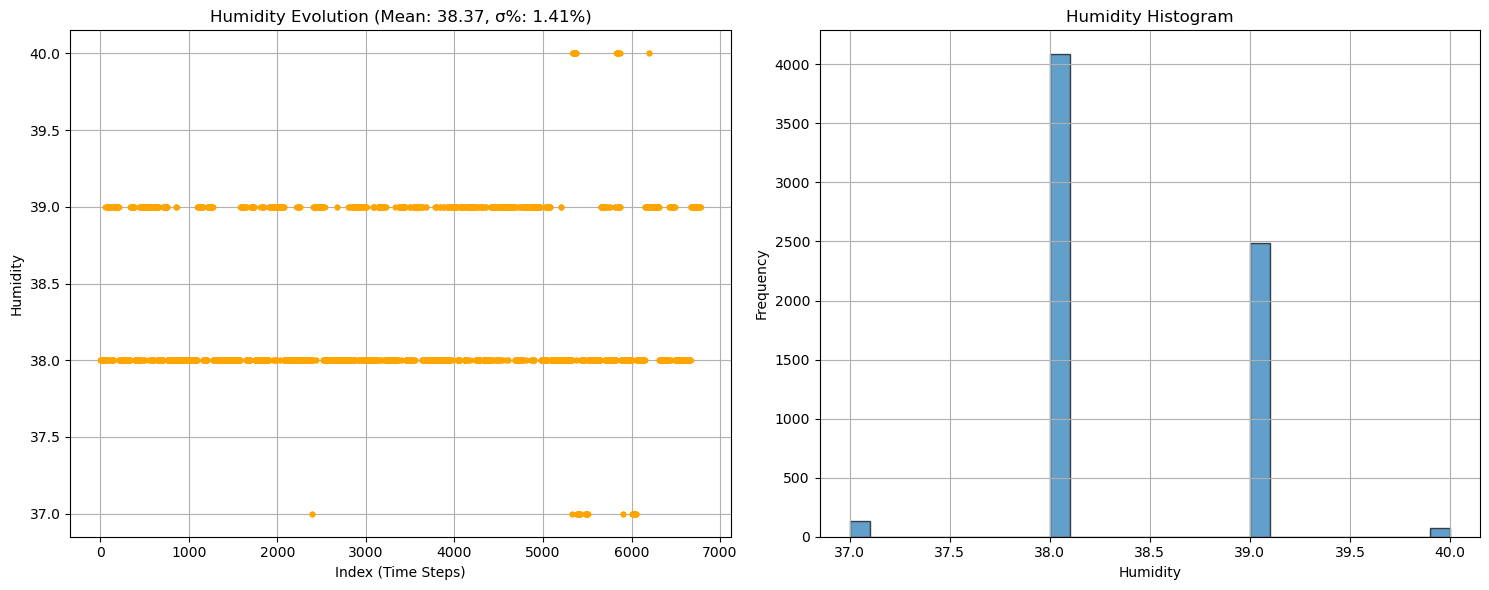

Total_Counts:
  Mean: 73668.75368731564
  Standard Deviation (σ): 95.05370773802066
  Standard Deviation as Percentage of Mean: 0.12902852699459622%


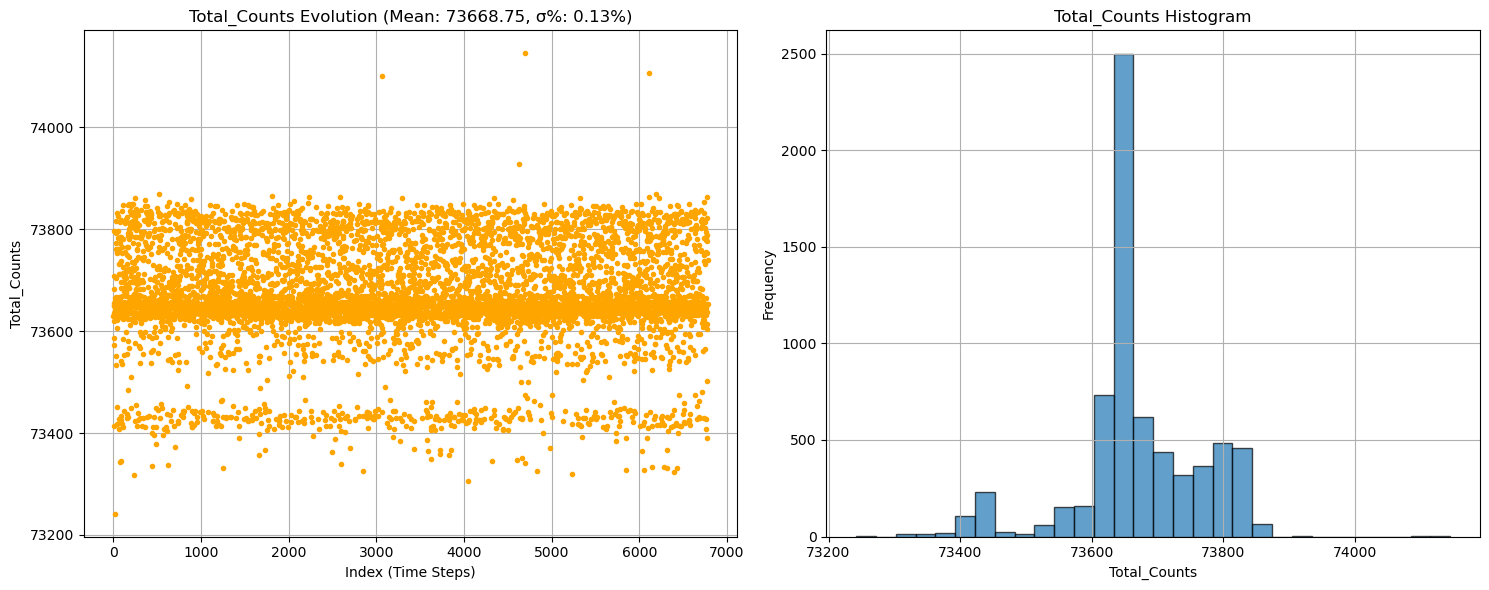

In [103]:
datasets = MergeDatasets('./Data/setup2/28102024_4L2/data')
# Plot each column except 'Date' and 'Time'
columns_to_plot = ['Laser_Power', 'Total_Sum', 'Total_Sqr', 'V_Mean', 'Std_V', 'Temp', 'Humidity', 'Total_Counts']

Overall_Stability(datasets,columns_to_plot)

Laser_Power:
  Mean: 131.48616666666666
  Standard Deviation (σ): 122.57471295500221
  Standard Deviation as Percentage of Mean: 93.22251614935581%


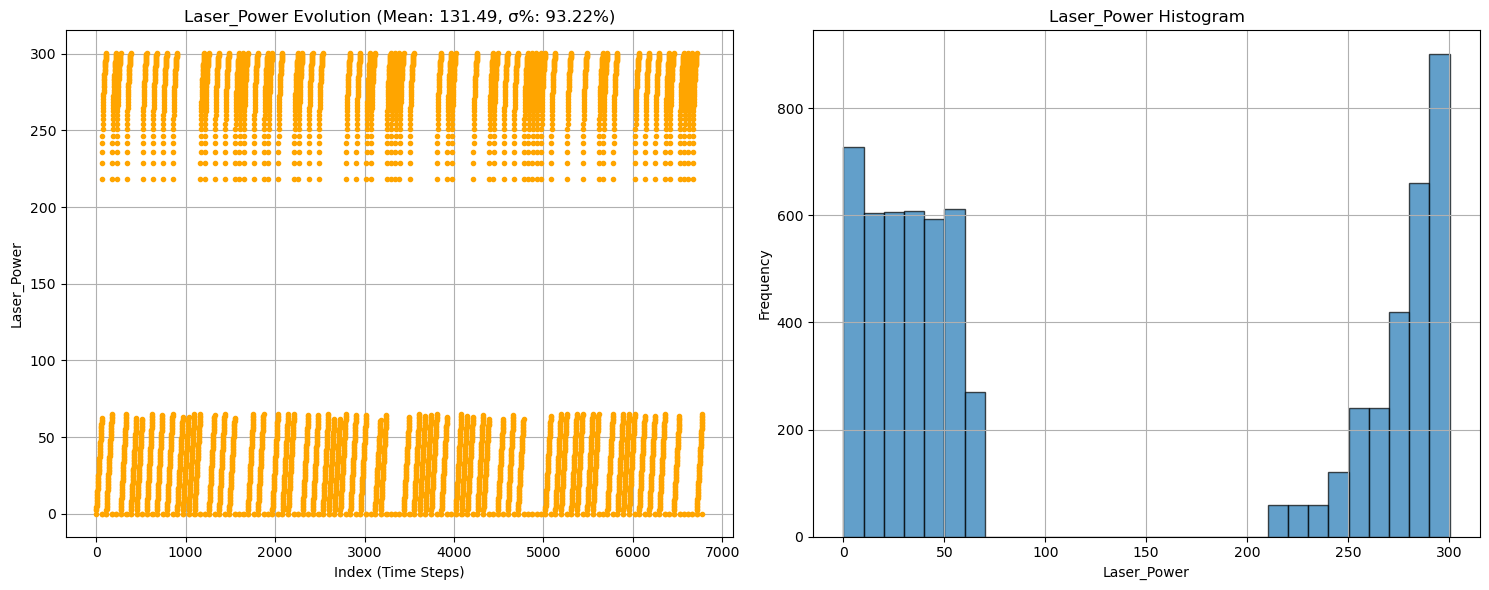

Total_Sum:
  Mean: 158696761.78053096
  Standard Deviation (σ): 94565393.05912049
  Standard Deviation as Percentage of Mean: 59.588735143757575%


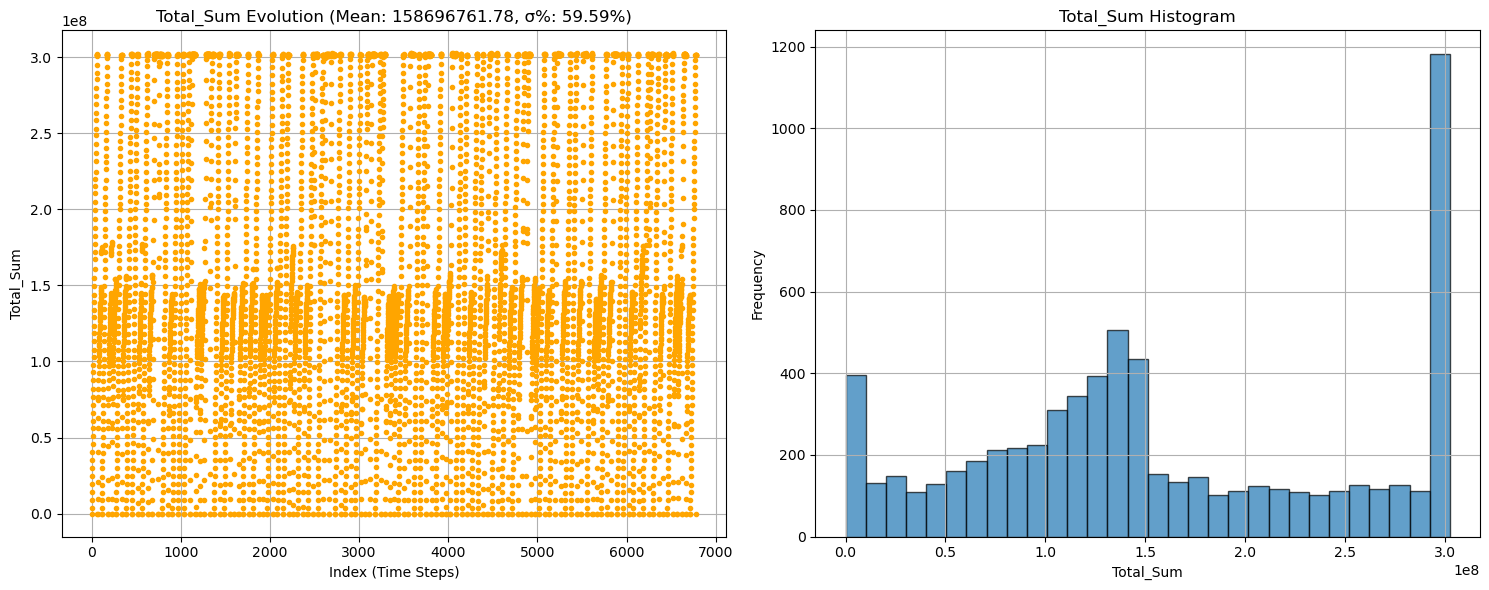

Total_Sqr:
  Mean: 463241747120.6522
  Standard Deviation (σ): 443729608932.36005
  Standard Deviation as Percentage of Mean: 95.78791455874331%


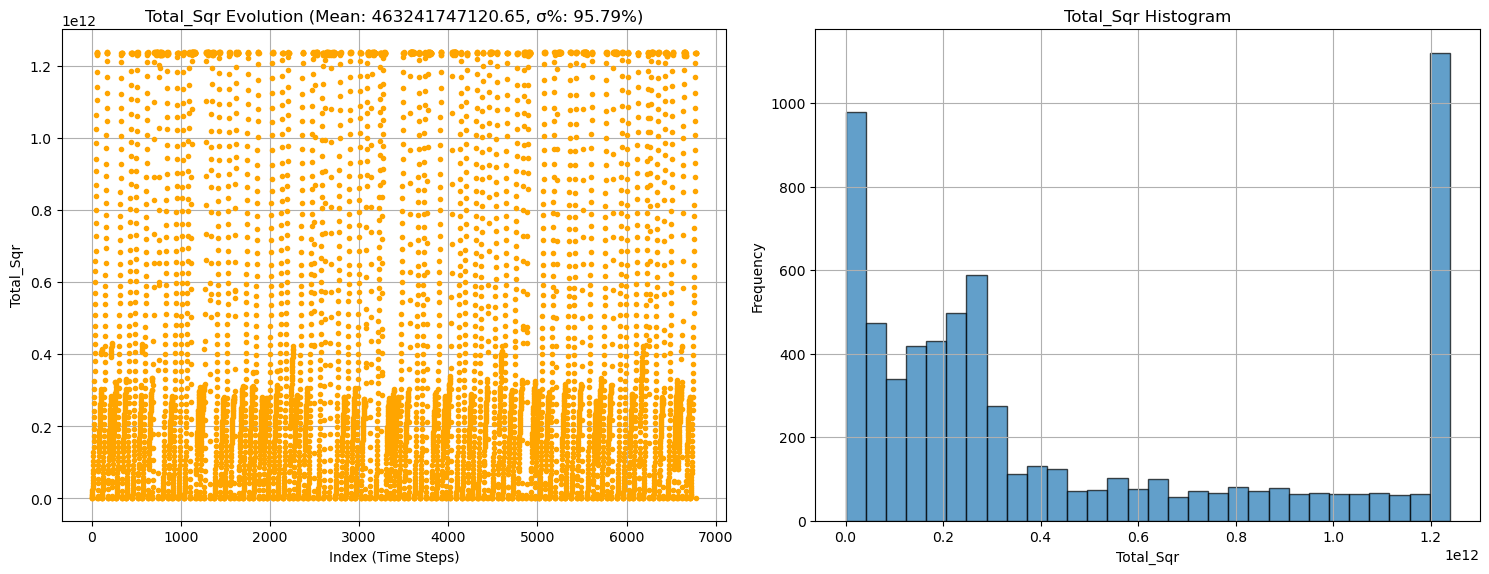

V_Mean:
  Mean: 1.4601769911504423e+34
  Standard Deviation (σ): 1.2023207647042113e+36
  Standard Deviation as Percentage of Mean: 8234.07554009551%


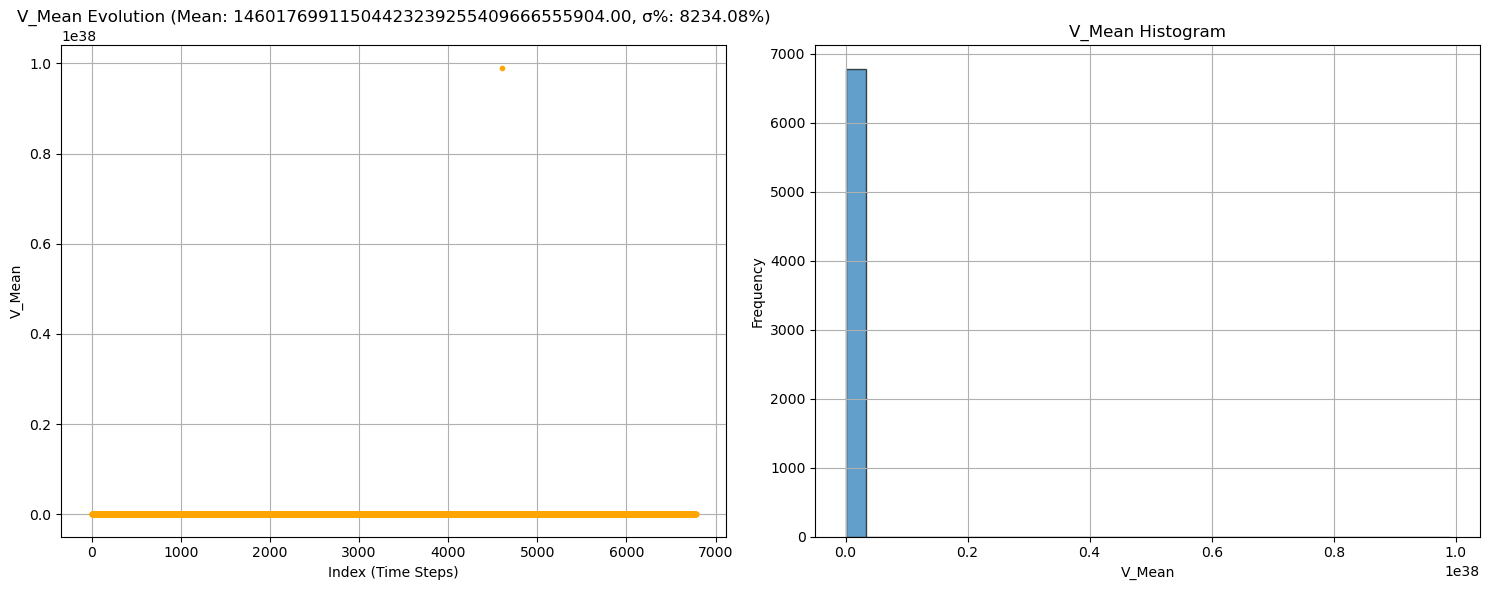

Std_V:
  Mean: 0.0009008527126843658
  Standard Deviation (σ): 0.0012392246341312728
  Standard Deviation as Percentage of Mean: 137.56129239358393%


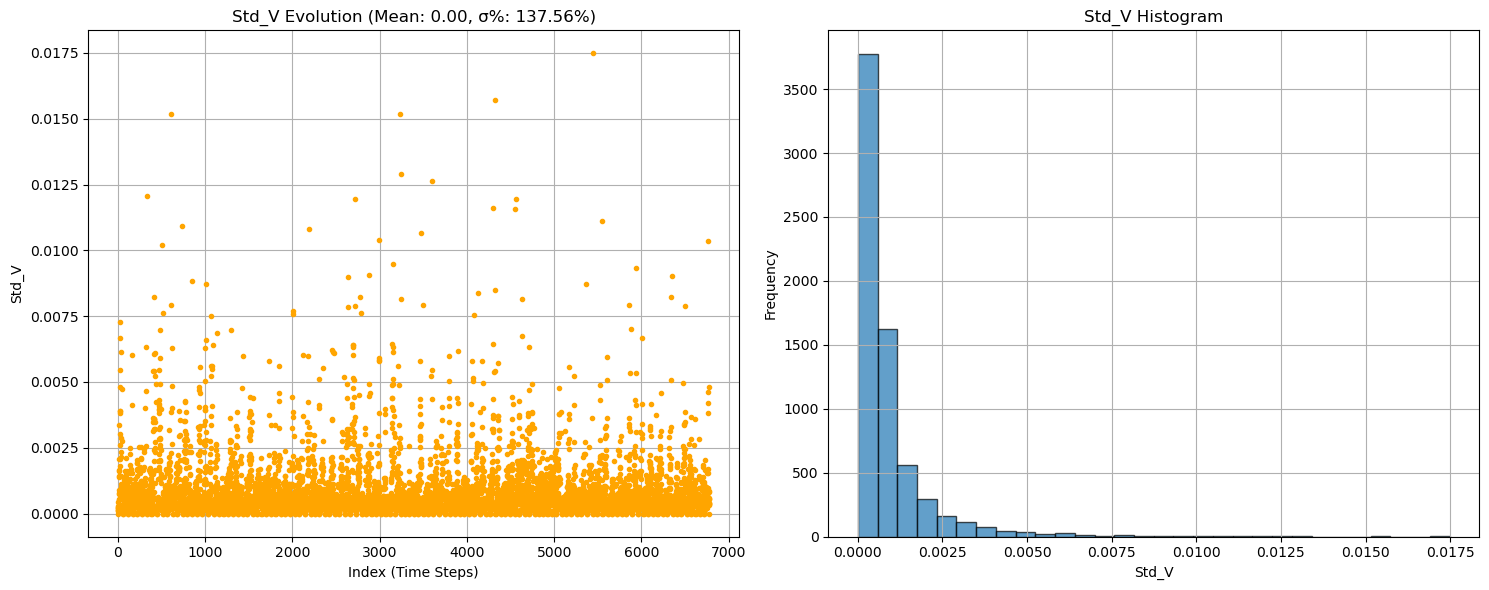

Temp:
  Mean: 20.52438053097345
  Standard Deviation (σ): 0.8800705943862892
  Standard Deviation as Percentage of Mean: 4.287927682193234%


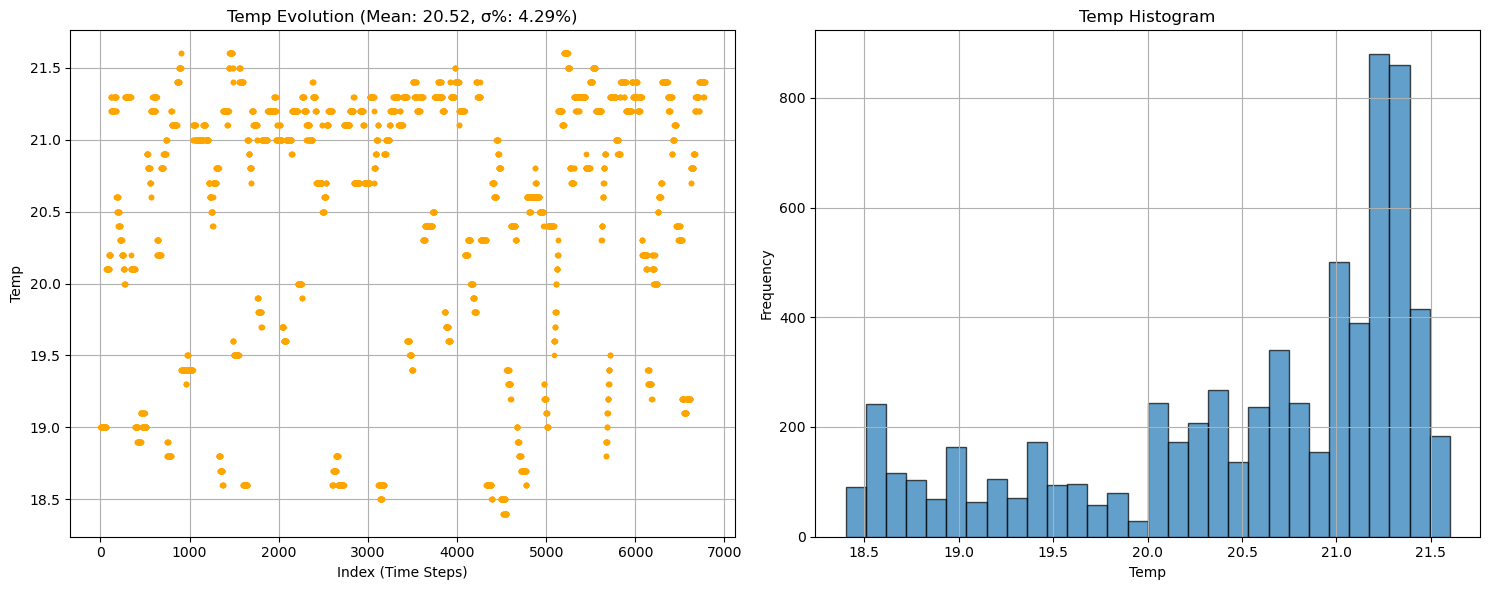

Humidity:
  Mean: 34.74483775811209
  Standard Deviation (σ): 2.062762428477355
  Standard Deviation as Percentage of Mean: 5.9368889353807655%


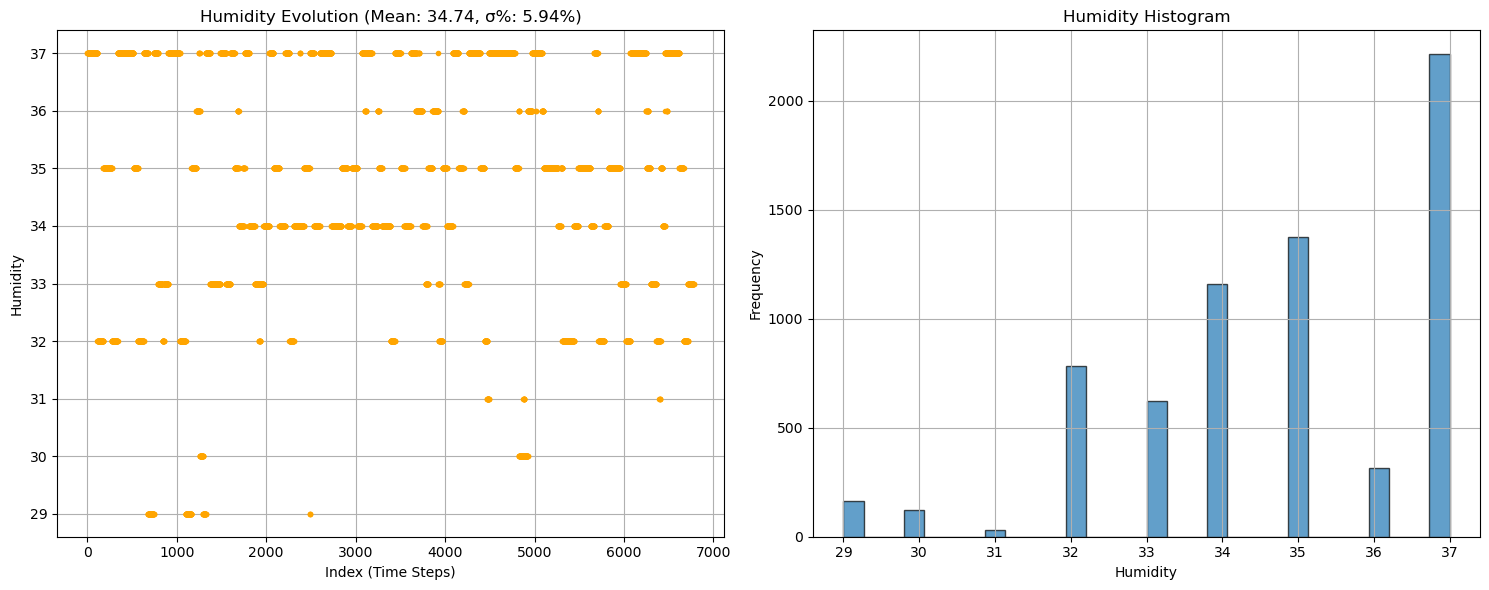

Total_Counts:
  Mean: 73671.11002949852
  Standard Deviation (σ): 102.49816876743549
  Standard Deviation as Percentage of Mean: 0.13912939376968037%


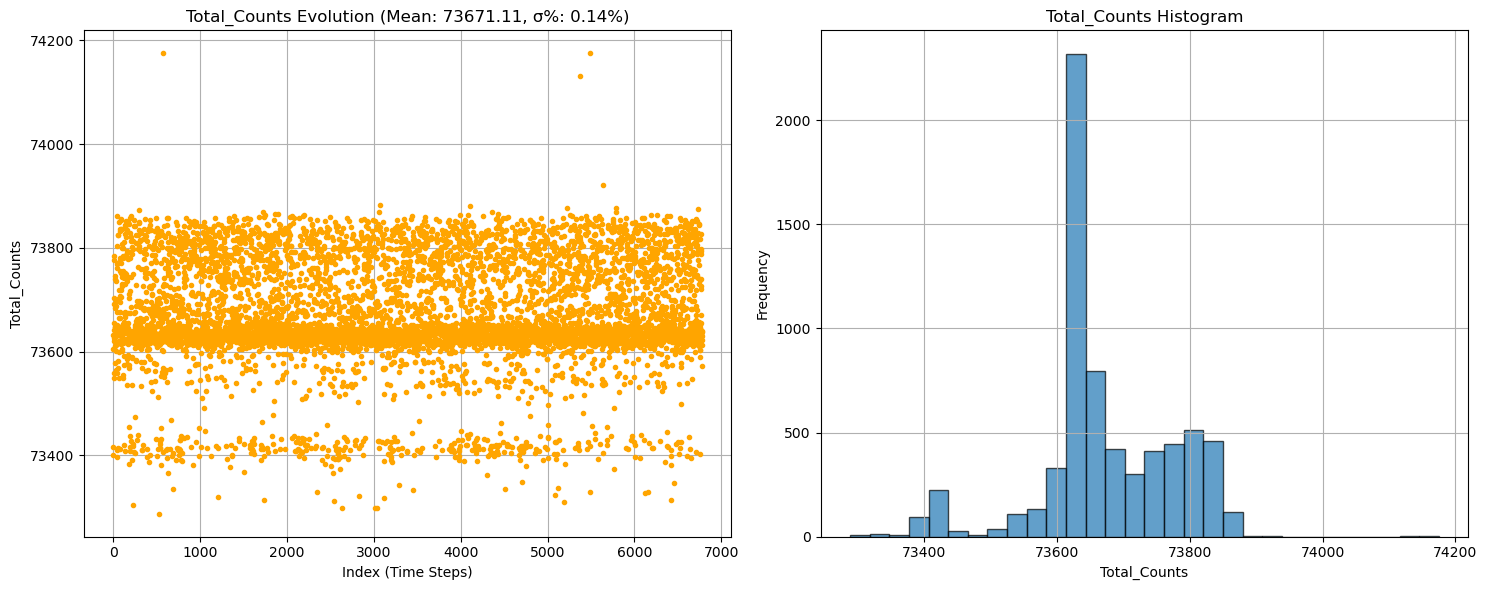

In [196]:
datasets = MergeDatasets('./Data/setup2/20112024_9R1/data')
# Plot each column except 'Date' and 'Time'
columns_to_plot = ['Laser_Power', 'Total_Sum', 'Total_Sqr', 'V_Mean', 'Std_V', 'Temp', 'Humidity', 'Total_Counts']

Overall_Stability(datasets,columns_to_plot)